In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/celeba.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import imageio
import PIL
import time
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [218, 218])
    image /= 255.0  # normalize to [0,1] range

    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


In [ ]:
path_to_imgs = os.path.join(os.getcwd().split('/src')[0])
full_img_path = os.path.join(path_to_imgs,"/content/files/celeba/")

# Get the image paths 
all_image_paths = [os.path.join(full_img_path,f) for f in os.listdir("/content/files/celeba/")]

image_count = len(all_image_paths)
BATCH_SIZE = 1
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)


# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: (None, 218, 218, 3), types: tf.float32>

In [ ]:
## Generator ##
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 112, 112, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32,(3, 3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(16,(3,3), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 224, 224, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(3, (7, 7), strides=(1, 1), padding='valid', use_bias=False))
    assert(model.output_shape == (None, 218, 218, 3))

    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_56 (Batc (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_86 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_51 (Conv2DT (None, 14, 14, 128)       294912    
_________________________________________________________________
batch_normalization_57 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_87 (LeakyReLU)   (None, 14, 14, 128)     

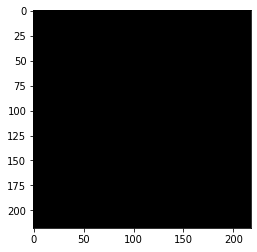

In [ ]:
generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, :])

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same', 
                                        input_shape=[218, 218, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    
    model.add(layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    model.add(layers.Dropout(0.3))
              
    model.add(layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.MaxPooling2D((2,2),strides=(2,2)))


    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 218, 218, 16)      448       
_________________________________________________________________
leaky_re_lu_97 (LeakyReLU)   (None, 218, 218, 16)      0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 109, 109, 16)      0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
leaky_re_lu_98 (LeakyReLU)   (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 54, 54, 32)      

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = '.training/training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS =400
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    print(type(images))
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        image_batch = next(iter(ds))
        #for image_batch in dataset:
        train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.subplots(4,4,figsize=(6,6))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
%%time
train(ds, EPOCHS)

Buffered data was truncated after reaching the output size limit.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

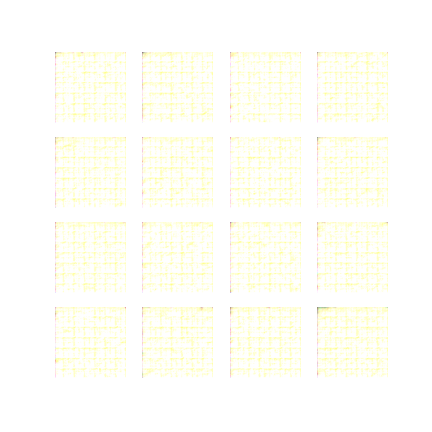

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [ ]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>